# Load Libraries

In [1]:
# numpy and pandas
import numpy as np
import pandas as pd
import math

# Generic
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Images
from PIL import Image
from skimage.transform import resize
import cv2
# import talos as ta

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, plot_confusion_matrix, roc_curve


# Tensorflow
import tensorflow as tf
# import tensorflow.compat.v1 as tf

# Keras
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.utils import print_summary
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau, Callback
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras import metrics
from matplotlib.ticker import MaxNLocator

Using TensorFlow backend.


# Global Parameters

In [44]:
perc_split = [0.7, 0.3, 0.0]
input_shape = (224, 224, 3)
seed = 1234
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Hyperparameters
batch_size = 64
epochs = 1000
learning_rate = 0.001


# Load Classes and Functions

### CheXnet

In [16]:
# chexNet weights
chexnet_weights = '/home/ygala/TFM_UOC/scripts/chexnet/best_weights.h5'

def chexnet_preprocess_input(value):
    return preprocess_input(value)


def get_chexnet_model():
    input_shape = (224, 224, 3)
    img_input = Input(shape=input_shape)
    base_weights = 'imagenet'

    # create the base pre-trained model
    base_model = DenseNet121(
        include_top=False,
        input_tensor=img_input,
        input_shape=input_shape,
        weights=base_weights,
        pooling='avg'
    )

    x = base_model.output
    # add a logistic layer -- let's say we have 14 classes
    predictions = Dense(
        14,
        activation='sigmoid',
        name='predictions')(x)

    # this is the model we will use
    model = Model(
        inputs=img_input,
        outputs=predictions,
    )

    # load chexnet weights
    model.load_weights(chexnet_weights)

    # return model
    return base_model, model

### Auxiliary functions

In [17]:
def get_class_weight(csv_file_path, target_class):
    df = pd.read_csv(csv_file_path, sep=';')
    total_counts = df.shape[0]
    class_weight = []

    ratio_pos = df.loc[(df[target_class] == 'Y')].shape[0] / total_counts
    ratio_neg = df.loc[(df[target_class] == 'N')].shape[0] / total_counts
    class_weight = np.array((ratio_pos, ratio_neg))
        
    return class_weight

def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc


def print_confidence_intervals(statistics):
    df = pd.DataFrame(columns=["Mean AUC (CI 5%-95%)"])
    mean = statistics.mean()
    max_ = np.quantile(statistics, .95)
    min_ = np.quantile(statistics, .05)
    df.loc["Exitus"] = ["%.2f (%.2f-%.2f)" % (mean, min_, max_)]
    return df


def get_model(learning_rate):
    # get base model, model
    base_model, chexnet_model = get_chexnet_model()

    x = base_model.output
    
    # Regularization layer
    x = BatchNormalization()(x)
    
    # Dense layer
    x = Dense(128, 
              activation='relu',
              kernel_regularizer=tf.keras.regularizers.l1_l2(0.5, 0.0001))(x)
    
    # Regularization layer
    x = BatchNormalization()(x)

    
    # add a logistic layer -- let's say we have 6 classes
    predictions = Dense(
        1,
        activation='sigmoid')(x)

    # this is the model we will use
    model = Model(
        inputs=base_model.input,
        outputs=predictions,
    )

    # first: train only the top layers (which were randomly initialized)

    for layer in base_model.layers:
        layer.trainable = False

    # initiate an Adam optimizer
    opt = Adam(
        lr=learning_rate,
        beta_1=0.9,
        beta_2=0.999,
        decay=0.0,
        amsgrad=False
    )

    # Let's train the model using Adam
    model.compile(
        loss='binary_crossentropy',
        optimizer=opt,
        metrics=[metrics.BinaryAccuracy(name = "acc"),
                metrics.AUC(name = "auc")])

    return base_model, model


class print_learning_rate(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        print(f'Learning rate = {K.eval(lr):.5f}')


### Print functions

In [18]:
def grafica_entrenamiento(tr_auc, val_auc, tr_loss, val_loss, best_i,
                          figsize=(10,5), path_results = None):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_loss)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_loss)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=12)
    plt.xlabel('época', fontsize=18)        
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    plt.subplot(1,2,2)
    
    plt.plot(1+np.arange(len(tr_auc)),  np.array(tr_auc))
    plt.plot(1+np.arange(len(val_auc)), np.array(val_auc))
    plt.plot(1+best_i, val_auc[best_i], 'or')
    plt.title('AUC', fontsize=18)
    plt.ylabel('AUC', fontsize=12)
    plt.xlabel('época', fontsize=18)    
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    if (path_results != None):
        plt.savefig(os.path.join(path_results, 'auc_loss.png'))
    plt.show()
    
class TrainingPlot(Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.auc = []
        self.val_losses = []
        self.val_auc = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):       
       
        
        # Before plotting ensure at least 10 epochs have passed
        if epoch > 20:
             # Append the logs, losses and accuracies to the lists
            self.logs.append(logs)        
            self.auc.append(logs.get('auc'))        
            self.val_auc.append(logs.get('val_auc'))
            self.losses.append(logs.get('loss'))
            self.val_losses.append(logs.get('val_loss'))
            best_i = np.argmax(self.val_auc)
            grafica_entrenamiento(self.auc, self.val_auc, self.losses, self.val_losses, best_i)


### Heatmaps functions

In [20]:
def show_heatmap(model, im, es_maligna, predictions):
    


    imag = np.reshape(im, (1, im.shape[0], im.shape[1], im.shape[2]))
        
    # This is the "benign" entry in the prediction vector
    output = model.output[0, 0]
    
    # The is the output feature map of the last convolutional layer
    last_conv_layer = model.get_layer('bn')
    
    # This is the gradient of the "benign" class with regard to
    # the output feature map of last convolutional layer
    grads = K.gradients(output, last_conv_layer.output)[0]
    
    
    # This function allows us to access the values of the quantities we just defined:
    # `pooled_grads` and the output feature map of the last convolutional layer
    # given a sample image
    iterate = K.function([model.input], [last_conv_layer.output, grads])
    
    # These are the values of these two quantities, as Numpy arrays,
    # given our sample image
    output, grads_val = iterate(imag)
    conv_layer_output_value, pooled_grads_value = output[0, :], grads_val[0, :, :, :]   
    
   
    
      
    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    weights = np.mean(pooled_grads_value, axis=(0, 1))
    cam = np.dot(conv_layer_output_value, weights)
    heatmap = np.maximum(cam, 0)
    heatmap /= np.max(heatmap)
    plt.matshow(heatmap)
    plt.show()
    
    # load the original image
    img = imag[0]
    
    # Process CAM
    cam = cv2.resize(cam, (img.shape[1], img.shape[0]), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()  


    
    # We resize the heatmap to have the same size as the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    # We convert the heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    
    # We apply the heatmap to the original image
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    superimposed_img = heatmap * 0.8 / 255 + 0.8*img

    
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(img, vmin=0, vmax=1)
    plt.subplot(1,3,2)
    plt.imshow(heatmap, vmin=0, vmax=1)
    plt.colorbar()
    plt.subplot(1,3,3)
    plt.imshow(img,
                       cmap='gray')
    plt.imshow(cam, cmap='jet', alpha=min(0.5, predictions[0]))
    plt.colorbar()
    plt.show()
    print("- Probabilidad de Exitus:", predictions[0])
    print("-", "Clase real:", "No sobrevive" if es_maligna else "Sobrevive")
    print("\n\n\n")
    return heatmap, superimposed_img

# Load Data

In [21]:
path_root = '/home/ygala/TFM_UOC/'
path_images = os.path.join(path_root, 'data', 'covid_images')


## Read data

In [ ]:
case_features = pd.read_csv(os.path.join(path_images, 'clean_data_1_filtered_2.csv'), sep=';');
case_features

## Split data

In [ ]:
target_class = 'survival'
np.random.seed(seed)

### Positive patient ids 
positive = case_features[case_features.survival.values == 'Y']
positive_ids = positive.patientid.unique()

### Negative patient ids 
negative = case_features[case_features.survival.values == 'N']
negative_ids = negative.patientid.unique()
n_negative_ids = len(negative_ids)

### Test
test_size = perc_split[2]*n_negative_ids
test_ids = np.append(np.random.choice(positive_ids, size = math.floor(test_size), replace = False),
                     np.random.choice(negative_ids, size = math.floor(test_size), replace = False))
positive_ids = positive_ids[~np.isin(positive_ids, test_ids)]
negative_ids = negative_ids[~np.isin(negative_ids, test_ids)]

### Val
val_size = perc_split[1]*n_negative_ids
val_ids = np.append(np.random.choice(positive_ids, size = math.floor(val_size), replace = False),
                     np.random.choice(negative_ids, size = math.floor(val_size), replace = False))
positive_ids = positive_ids[~np.isin(positive_ids, val_ids)]
negative_ids = negative_ids[~np.isin(negative_ids, val_ids)]

### Train
train_ids = np.append(positive_ids,
                    negative_ids)

# Split dataset based on patient ids
case_features_train = case_features[case_features.patientid.isin(train_ids)]
case_features_val = case_features[case_features.patientid.isin(val_ids)]
# case_features_test = case_features[case_features.patientid.isin(test_ids)]

# Selección del patrón de datos X y del target y
ytrain = case_features_train[target_class]
del case_features_train[target_class]
Xtrain = case_features_train

yval = case_features_val[target_class]
del case_features_val[target_class]
Xval = case_features_val

ytest = case_features_test[target_class]
del case_features_test[target_class]
Xtest = case_features_test



In [24]:
print(len(case_features_train[ytrain == "Y"].patientid.unique()))
print(len(case_features_train[ytrain == "N"].patientid.unique()))
print(len(case_features_val[yval == "Y"].patientid.unique()))
print(len(case_features_val[yval == "N"].patientid.unique()))

829
94
39
39


In [25]:
print(case_features.shape)
print(case_features_train.shape)
print(case_features_val.shape)

(1278, 41)
(1171, 40)
(107, 40)


In [26]:
print(ytrain.value_counts())
print(yval.value_counts())

Y    1033
N     138
Name: survival, dtype: int64
N    55
Y    52
Name: survival, dtype: int64


## Read images

### Train

In [27]:
X_train = []
for i in range(Xtrain.shape[0]):
    # print('%0.2f%%' % float(100*i/Xtrain.shape[0]))
    image_path = os.path.join(path_images, 'processed', Xtrain.iloc[i].filename)
    imagen = Image.open(image_path)
    imagen = np.asarray(imagen.convert("RGB"))
    imagen = resize(imagen,  input_shape)
    X_train.append(imagen)

X_train = np.stack(X_train, axis = 0)
np.save(os.path.join(path_images, 'X_train.npy'), X_train)
print(X_train.shape)

(1171, 224, 224, 3)


### Validation

In [28]:
X_val = []
for i in range(Xval.shape[0]):
    # print('%0.2f%%' % float(100*i/Xval.shape[0]))
    image_path = os.path.join(path_images, 'processed', Xval.iloc[i].filename)
    imagen = Image.open(image_path)
    imagen = np.asarray(imagen.convert("RGB"))
    imagen = resize(imagen,  input_shape)
    X_val.append(imagen)

X_val = np.stack(X_val, axis = 0)
np.save(os.path.join(path_images, 'X_val.npy'), X_val)
print(X_val.shape)

(107, 224, 224, 3)


### Test

In [29]:
X_test = []
for i in range(Xtest.shape[0]):
     # print('%0.2f%%' % float(100*i/Xtest.shape[0]))
    image_path = os.path.join(path_images, 'processed', Xtest.iloc[i].filename)
    imagen = Image.open(image_path)
    imagen = np.asarray(imagen.convert("RGB"))
    imagen = resize(imagen,  input_shape)
    X_test.append(imagen)

X_test = np.stack(X_test, axis = 0)
np.save(os.path.join(path_images, 'X_test.npy'), X_test)


## Set target

### Train

In [30]:
ytrain[ytrain=='Y'] = 0
ytrain[ytrain=='N'] = 1
y_train = np.array(ytrain, dtype = np.int64)
y_train.shape
np.save(os.path.join(path_images, 'y_train.npy'), y_train)

/usr/local/miniconda/python-3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/miniconda/python-3.6/lib/python3.6/site-packages/pandas/core/generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/usr/local/miniconda/python-3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

(1171,)

### Validation

In [31]:
yval[yval=='Y'] = 0
yval[yval=='N'] = 1
y_val = np.array(yval, dtype = np.int64)
y_val.shape
#np.save(os.path.join(path_images, 'y_val.npy'), y_val)

/usr/local/miniconda/python-3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/miniconda/python-3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(107,)

### Test

In [32]:
ytest[ytest=='Y'] = 0
ytest[ytest=='N'] = 1
y_test = np.array(ytest, dtype = np.int64)

np.save(os.path.join(path_images, 'y_test.npy'), y_test)

In [33]:
X_train = np.load(os.path.join(path_images, 'X_train.npy'))
X_val = np.load(os.path.join(path_images, 'X_val.npy'))
X_test = np.load(os.path.join(path_images, 'X_test.npy'))
y_train = np.load(os.path.join(path_images, 'y_train.npy'))
y_val = np.load(os.path.join(path_images, 'y_val.npy'))
y_test = np.load(os.path.join(path_images, 'y_test.npy'))

## Set class weights

In [34]:
# train
ratio_pos = np.count_nonzero(y_train == 0) / len(y_train)
ratio_neg = np.count_nonzero(y_train == 1) / len(y_train)
class_weight_train = np.array((ratio_pos, ratio_neg))

# val
ratio_pos = np.count_nonzero(y_val == 0) / len(y_val)
ratio_neg = np.count_nonzero(y_val == 1) / len(y_val)
class_weight_val = np.array((ratio_pos, ratio_neg))

# test
ratio_pos = np.count_nonzero(y_test == 0) / len(y_test)
ratio_neg = np.count_nonzero(y_test == 1) / len(y_test)
class_weight_test= np.array((ratio_pos, ratio_neg))

# Print
print(class_weight_train)
print(class_weight_val)
print(class_weight_test)


[0.88215201 0.11784799]
[0.48598131 0.51401869]


# Model Definition

## Callbacks

### Checkpoints

In [35]:
save_dir = os.path.join(
    os.getcwd(),
    '../saved_models'
)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

# This callback saves the weights of the model after each epoch
checkpoint = ModelCheckpoint(
    '../saved_models/weights.epoch_{epoch:02d}.hdf5',
    monitor='val_loss', 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto',
    verbose=1
)

# This callback writes logs for TensorBoard
tensorboard = TensorBoard(
    log_dir='./Graph', 
    histogram_freq=0,  
    write_graph=True
)



early_stopping = EarlyStopping(monitor='val_auc', patience=400, verbose=1, mode='max', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=250, mode='min')


callbacks_list = [early_stopping, plot_losses, print_lr]


## Original dataset

## Define CNN structure

In [36]:
# Fixed
base_model, model = get_model(learning_rate)

In [37]:
# Show layers
print_summary(model)

# Data Modeling

### Training

In [ ]:
###### ENTRENAMIENTO

epochs = [ 10000]
batch_size = [32, 64, 128]
learning_rate = [0.1, 0.01, 0.001]

previous_val_auc = 0
df = pd.DataFrame()

for e in epochs:
    for b in batch_size:
        for l in learning_rate:
            print("Numero de épocas", e,", batch size", b,  ", learning rate", l)

            ###### ENTRENAMIENTO
            out = model.fit(X_train, y_train,
                            validation_data=(X_val, y_val),
                            steps_per_epoch=len(X_train) / b, 
                            epochs=e,
                            class_weight=class_weight_train,
                            callbacks = callbacks_list_augmented,       
                            verbose=0)

            train_loss = out.history['loss'][-1]
            val_loss = out.history['val_loss'][-1]
            train_auc = out.history['auc'][-1]
            val_auc = out.history['val_auc'][-1]
            stopped_epoch = my_callbacks.stopped_epoch
            model = out.model
            
            res = pd.DataFrame([e, l, b, stopped_epoch, train_loss, val_loss, train_auc, val_auc])
            df = pd.concat([df, res], axis=1)

            df.to_csv('model_results34.csv') 
            
            if(previous_val_auc < val_auc):
                save_dir = os.path.join(
                    os.getcwd(),
                    '../model_results_y'
                )
                if not os.path.isdir(save_dir):
                    os.makedirs(save_dir)
                model.save('../../model_results_y/model.h5')
                
                previous_val_auc = val_auc
                
            for e in range(epochs):    
                acum_tr_acc = acum_tr_acc + history.history['accuracy']
                acum_val_acc = acum_val_acc + history.history['val_accuracy']

                if len(acum_tr_acc) > 1:
                    clear_output()
                    grafica_entrenamiento(acum_tr_acc, acum_val_acc)
                           
df.index = ['epochs', 'learning_rate', 'batch_size',
            'early_stopping', 'train_loss', 'val_loss', 'train_auc', 'val_auc']
df.to_csv('model_results3.csv') 

In [39]:
save_dir = os.path.join(os.getcwd(),'final_model_results')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model.save(os.path.join(save_dir, 'model.h5')) 

### Predict

In [ ]:
pred_train = model.predict(X_train)
pred_val = model.predict(X_val)
pred_test = model.predict(X_test)

### Metrics

In [ ]:
auc_train = roc_auc_score(y_true = y_train, y_score = pred_train)
auc_val = roc_auc_score(y_true = y_val, y_score = pred_val)
auc_test = roc_auc_score(y_true = y_test, y_score = pred_test)
print('AUC train = %s - AUC val = %s - AUC test = %s' % (str(auc_train), str(auc_val), str(auc_test)))

In [ ]:
y_labels_train = (pred_train >= 0.5).astype(int)
y_labels_val = (pred_val >= 0.5).astype(int)
y_labels_test = (pred_test >= 0.5).astype(int)
cm_train = confusion_matrix(y_pred = y_labels_train, y_true = y_train)
cm_val = confusion_matrix(y_pred = y_labels_val, y_true = y_val)
cm_test = confusion_matrix(y_pred = y_labels_test, y_true = y_test)
print(cm_train)
print(cm_val)
print(cm_test)

### Save output

In [ ]:
Xtrain.to_csv(os.path.join(save_dir, 'predictions', 'X_train.csv'))
np.savetxt(os.path.join(save_dir, 'predictions', 'predictions_train_augmented.csv'), pred_train, delimiter=";")
np.savetxt(os.path.join(save_dir, 'predictions','y_train.csv'), y_train, delimiter=";")
Xval.to_csv(os.path.join(save_dir, 'predictions', 'X_val.csv'))
np.savetxt(os.path.join(save_dir, 'predictions', 'predictions_val_augmented.csv'), pred_val, delimiter=";")
np.savetxt(os.path.join(save_dir, 'predictions','y_val.csv'), y_val, delimiter=";")
Xtest.to_csv(os.path.join(save_dir, 'predictions','X_test.csv'))
np.savetxt(os.path.join(save_dir, 'predictions','predictions_test_augmented.csv'),pred_test, delimiter=";")
np.savetxt(os.path.join(save_dir, 'predictions','y_test.csv'), y_test, delimiter=";")

# Results

## AUC confidence intervals

In [ ]:
AUC_CI_train = bootstrap_auc(y_train, pred_train, bootstraps = 100, fold_size = 1000,)
AUC_CI_val = bootstrap_auc(y_val, pred_val, bootstraps = 100, fold_size = 1000)
AUC_CI_test = bootstrap_auc(y_test, pred_test, bootstraps = 100, fold_size = 1000,)
AUC_CI = print_confidence_intervals(AUC_CI_train,)
AUC_CI = AUC_CI.append(print_confidence_intervals(AUC_CI_val), ignore_index=True)
AUC_CI = AUC_CI.append(print_confidence_intervals(AUC_CI_test), ignore_index=True)
AUC_CI.index = ['Train', 'Val', 'Test'];

## Plot AUC

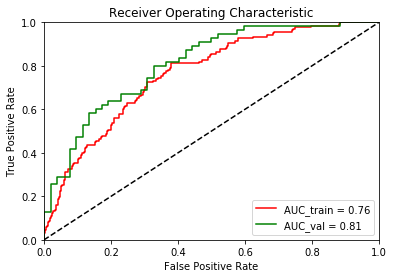

In [48]:
fpr_train, tpr_train, threshold_train = roc_curve(y_train, pred_train)
roc_auc_train = roc_auc_score(y_true = y_train, y_score = pred_train)
fpr_val, tpr_val, threshold_val = roc_curve(y_val, pred_val)
roc_auc_val = roc_auc_score(y_true = y_val, y_score = pred_val)
# fpr_test, tpr_test, threshold_test = roc_curve(y_test, pred_test)
# roc_auc_test = roc_auc_score(y_true = y_test, y_score = pred_test)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_train, tpr_train, 'r', label = 'AUC_train = %0.2f' % roc_auc_train)
plt.plot(fpr_val, tpr_val, 'g', label = 'AUC_val = %0.2f' % roc_auc_val)
#plt.plot(fpr_test, tpr_test, 'b', label = 'AUC_test = %0.2f' % roc_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Heatmap / Gradcam

In [ ]:
new_X_test = X_test[:, 0:185, :, :]
new_X_test.shape

In [ ]:
i = np.argmax(pred_test)
print('index ' + str(i));
heat_map, superimposed_img = show_heatmap(model, new_X_test[i], y_test[i], pred_test[i])

In [ ]:
i = np.argmin(pred_test)
print('index ' + str(i));
heat_map, superimposed_img = show_heatmap(model, new_X_test[i], y_test[i], pred_test[i])

In [ ]:
for i in np.where(y_test == 1)[0]:
    print('index ' + str(i));
    heat_map, superimposed_img = show_heatmap(model, new_X_test[i], y_test[i], pred_test[i])

In [ ]:
for i in np.where(y_test == 0)[0]:
    print('index ' + str(i));
    heat_map, superimposed_img = show_heatmap(model, new_X_test[i], y_test[i], pred_test[i])